# Physics 5730 - Homework 2

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

## Problem 1

Consider a binomial distribution, which describes the probability of k successes in n Bernoulli trials as follows: 

$$ f = {{n}\choose{k}} p^{k} (1 - p)^{n - k} $$

where ${n}\choose{k}$ is the binomial coefficient n_choose_k (this is provided numerically by python function scipy.special.comb).
Now let’s say that we flipped a coin with bias p many times (n) and observed some successes (k). Here n and k are known and we want to determine the bias p as well as place error bars on our estimate.
1. Calculate analytically Fisher information for n binomial r.v.’s as well as the MLE 𝑝̂ for the bias parameter p.
2. Using the results from step 1, provide a numerical means to calculate a 95% C.I. for any given 𝑝̂.
3. How well does this approach work? Provide code to test many cases. Identify situations where
this approach to C.I. is clearly deficient and explain in your comments or other document the
nature of the deficiency.
4. Now let us consider the “exact” C.I. which we can construct explicitly from first principles.
Start at p=0.5 and lower this parameter value gradually numerically. At every iteration, compute the probability of k or more successes. You can stop right at the point when this net probability becomes lower than 0.025. This value of p is the lower value of the exact confidence limit. Again, start at p=0.5 and raise this parameter value gradually numerically. At every iteration, compute the probability of k or less successes. You can stop right at the point when this net probability becomes lower than 0.025. This value of p is the lower value of the exact confidence limit.
Provide code to compute this “exact” C.I. and compare it’s performance with the MLE C.I. in cases where you think MLE C.I. is deficient.

In [1]:
# Problem 1
#
# This program
#
# @author Scott Merkley
# @version January 28, 2022

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import special
from scipy import stats
import warnings
warnings.filterwarnings('ignore')



# Creating N random variables
N = 100000

### 1.

# Using a binomial distribution
L = np.random.binomial(10, 0.45, N)
pHat = np.mean(L)

# Finding the fisher information for 1 and N
fisherInformation1 = 1 / (pHat * (1 - pHat))
fisherInformationN = N * fisherInformation1

# Finding sigma of the data
sigma = 1 / np.sqrt(abs(fisherInformationN))

# finding the zscore for the data
zScore = abs(stats.norm.ppf((1 - 0.975) / 2, loc = 0, scale = 1 ))

# Printing error bar size and confidence interval to the user
print(f'Error bar size is: {zScore * sigma}')
print(f'The 95% confidence interval for P is : \n{(pHat - zScore * sigma, pHat + zScore * sigma)}')



### 2.

# Adding error into the system in the form of normal distributed error

noisyL = np.random.binomial(10, 0.45, N) + np.random.normal(0, 1, N)
noisyPHat = np.sum(noisyL) / N
noisyFisherInformation1 = 1 / (noisyPHat * (1 - noisyPHat))
noisyFisherInformationN = N * noisyFisherInformation1
noisySigma = 1 / np.sqrt(abs(noisyFisherInformationN))
noisyZScore = abs(stats.norm.ppf((1 - 0.975) / 2, loc = 0, scale = 1))

print(f'\nNoisy error bar size is: {noisyZScore * noisySigma}')
print(f'The 95% confidence interval for noisyP is : \n{(noisyPHat - noisyZScore * noisySigma, noisyPHat + noisyZScore * noisySigma)}')



### 3.

# creating a function to quickly plug in different values for N
def ConfidenceInterval(N):
    # Using a binomial distribution
    L = np.random.binomial(10, np.random.random(), N)
    pHat = np.sum(L) / N

    # Finding the fisher information for 1 and N
    fisherInformation1 = 1 / (pHat * (1 - pHat))
    fisherInformationN = N * fisherInformation1

    # Finding sigma of the data
    sigma = 1 / np.sqrt(fisherInformationN)

    # finding the zscore for the data
    zScore = abs(stats.norm.ppf((1 - 0.975) / 2, loc = 0, scale = 1 ))

    # Printing error bar size and confidence interval to the user
    print(f'Error bar size is: {zScore * sigma}')
    print(f'The 95% confidence interval for P is : \n{(pHat - zScore * sigma, pHat + zScore * sigma)}')

# Run the function multiple times over different values of N
# for N in range(1, 10):
#     print(f'\nRun {N}: ')
#     ConfidenceInterval(N)



### 4.

# First we will start by making a function that takes in the parameter p so we can easily plug through these values to find the confidence intervals
def MLEConfidenceInterval(p):
    N = 1000
    
    # Using a binomial distribution
    L = np.random.binomial(10, p, N)
    probL = (sum(L == 0) / N)
    
    return probL
    
    
for i in range(500, 1, -1):
    prob = 0.025
    if(MLEConfidenceInterval(i * 1e-3) > prob):
        print(f'\nThe smallest p = {i * 1e-3} gives back a probability {MLEConfidenceInterval(i * 1e-3)} < {prob}')
        break
    

Error bar size is: 0.0281659577374184
The 95% confidence interval for P is : 
(4.476954042262581, 4.5332859577374185)

Noisy error bar size is: 0.028231481099308214
The 95% confidence interval for noisyP is : 
(4.486060712763442, 4.542523674962058)

The smallest p = 0.338 gives back a probability 0.017 < 0.025


## Problem 2

Write code which estimates the α quantile of the data and its C.I. using empirical likelihood method. For example, if α=0.50 then this would estimate a median (0.50 of the data above the estimate and 0.50 of the data below the estimate). You can assume that the data has no ties.

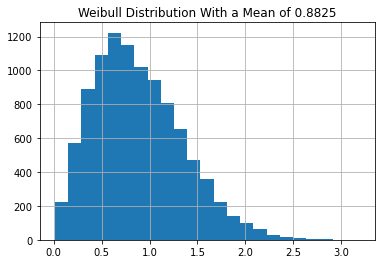

Ground truth: 0.8862269254527579
Actual Mean of Data: 0.8825012804774924


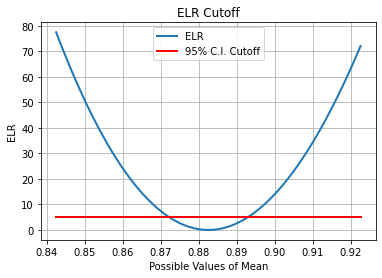

In [3]:
# Problem 2
#
# This program estimates the alpha quantile and its confidence interval using emperical likelihood method
#
# @author Scott Merkley
# @version January 28, 2022

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as SciOpt
import scipy.special as SciSpec
import scipy as sp
import scipy.stats as stats
import scipy.stats.distributions as spDist

N = int(1e4)
shape = 2

# Creating a random variable vector with Weibull Distribution and shape of 2
rvvec = np.random.weibull(shape, (N, 1))

# estimating function
targetValue = 0.826
count = 0
for i in range(len(rvvec)):
    if(rvvec[i] < targetValue):
        count += 1
# print((count / len(rvvec)))

# Plotting Data
plt.title(f'Weibull Distribution With a Mean of {np.mean(rvvec):0.5}')
plt.hist(rvvec, 23)
plt.grid()
plt.show()
print(f'Ground truth: {SciSpec.gamma(1 + 1 / shape)}')
print(f'Actual Mean of Data: {np.mean(rvvec)}')


# Making an ELR function to find the root of data using a given quantile
#
# @param data - data as an array
# @param Val - tentative value for being estimated, for this assignment is the given quantile
# @param alpha - desired quantile of data
def ELR(data, Val, alpha):
    # When averaged over the data dn set to zero gives the desired condition
    g = data - np.quantile(Val, alpha) # Change this for this assignment  \\np.quantile(rvvec, 0.5)
    # find the difference between data and quantile
    # Val is the quantile aka. for this 0.5
    # qualtile of the data that we are looking at
    # data val - 0.5
    # np.quantile(0.5, data) - val
    constraintEqn = lambda L : sum(g / (1 + g * L)) # Set up Lagrange Multiplier Condition for Lambda
    Lam = SciOpt.fsolve(constraintEqn, 0) # just solves the constraint equation for lambda so we have a Lagrange Multiplier
    return 2 * np.sum(np.log(1 + Lam * g))


N = 100
    
# Picking ranges for the mean
cutoff = 0.04
x = np.linspace(np.mean(rvvec) - cutoff, np.mean(rvvec) + cutoff, N)

# Setting up an indexing variable (ps. i have never done this before)
t = np.linspace(0, len(x) - 1, len(x)).astype(int)

# Now its time to start storing some ELR values in y but we are going to initialize it first
y = 0 * x

# Computing an ELR value for every possible mean value in our range
for i in t:
    y[i] = ELR(rvvec, x[i], 0.5)
    
# Plot the output to the user
plt.title('ELR Cutoff')
plt.plot(x, y, label = 'ELR', linewidth = 2)
plt.plot(x, x * 0 + spDist.chi2.ppf(0.975, df = 1), 'r', label = '95% C.I. Cutoff', linewidth = 2)
plt.xlabel('Possible Values of Mean')
plt.ylabel('ELR')
plt.legend()
plt.grid()
plt.show()

minELR = x[np.argmin(y)]

## Problem 3

Conduct a study on how empirical likelihood C.I. estimation works for Generalized Pareto Distribution.

$$f(x|K, S, T) = \frac{1}{S} (1 + K * \frac{x - T}{S})^{-1-\frac{1}{K}}$$

This distribution has three parameters: tail index (shape) parameter K, scale parameter S, and threshold (location) parameter T. S and T parameters are kind of boring so let’s fix them at S=1 and T=0.
- Note 1: In python, you are likely using scipy.stats.genpareto, in which c1ase the choice of S=1 and T=0 is already coded in and you only have the shape parameter (called C rather than K in standard python reference): 

$$f(x|C) = (1 + C * x)^{-1-\frac{1}{C}}$$

With this simplification, we can focus on the shape parameter and see how well empirical likelihood does for its estimation in the range between $\frac{1}{2}$ and 2. Comment on any trends you observe as you change the shape parameter.
- Note 2: The range between $\frac{1}{2}$ and 2 was chosen specifically to make this assignment a bit more interesting. Choose your estimating function carefully. Think about error propagation through your computation.

In [13]:
# Problem 3
#
# This program is creating a Generalized Pareto Distribution and analyzing it
#
# @author Scott Merkley
# @version January 28, 2022

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

N = 1000
C = 0.1

x = np.linspace(0.5, 2, N)

# Making the ppf of pareto distribution
y = stats.genpareto.pdf(x, N)

# Plotting the Pareto Distribution
# plt.title("Pareto Distribution")
# plt.hist(y, np.sqrt(N).astype(int))
# plt.grid()
# plt.show()


# Finding the Confidence Interval for the Pareto Distribution
L = y
pHat = np.sum(L) / N

# Finding the fisher information for 1 and N
fisherInformation1 = (- C - 1)**2 / (C * pHat + 1)**2
fisherInformationN = N * fisherInformation1

# Finding sigma of the data
sigma = 1 / np.sqrt(fisherInformationN)

# finding the zscore for the data
zScore = abs(stats.norm.ppf((1 - 0.975) / 2, loc = 0, scale = 1 ))

# Printing error bar size and confidence interval to the user
print(f'Error bar size is: {zScore * sigma}')
print(f'The 95% confidence interval for P is : \n{(pHat - zScore * sigma, pHat + zScore * sigma)}')


Error bar size is: 0.06444170775912691
The 95% confidence interval for P is : 
(-0.06352454316316448, 0.06535887235508935)
